In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# A custom function to calculate
# probability distribution function
from datetime import datetime

def value_counts(l):
    count_map = {}
    for i in l:
        if i in count_map:
            count_map[i] += 1
        else:
            count_map[i] = 1
    return count_map

def pdf(x, mean=None):
    if mean is None:
        mean = np.mean(x)
    std = np.std(x)
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out

def get_bell_for_week(peak_around_day=4):
    x = np.arange(1, 8, 1)
    probs = pdf(x, peak_around_day)
    s = sum(probs)
    diff = (1 - sum(probs))/7
    probs += diff
    return x, probs

def get_bell_for_month(month, year, peak_around_day=23, peek_around_weekday=4):
    is_leap_year = year%4 == 0
    if is_leap_year and month == 2:
        no_of_days = 29
    else:
        days_in_months = [21, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        no_of_days = days_in_months[month-1]
    x = np.arange(1, no_of_days+1, 1)
    probs = pdf(x, peak_around_day)
    # print(probs)
    _, week_probs = get_bell_for_week(peek_around_weekday)
    for i in range(len(probs)):
        week_day = datetime(year, month, i+1).weekday()
        probs[i] = probs[i] * week_probs[week_day-1]
    s = sum(probs)
    probs = [round((i/s), 3) for i in probs ]
    diff = (1 - sum(y))/no_of_days
    probs += diff
    return x, probs

def get_bell_for_year(peak_around_month=11):
    x = np.arange(1, 13, 1)
    probs = pdf(x, peak_around_month)
    s = sum(probs)
    diff = (1 - sum(probs))/12
    probs += diff
    return x, probs

def random_distribution(count, min_val=0, max_val=1, sort=False, order='asc'):
    r = [random.uniform(min_val, max_val) for i in range(count)]
    if sort:
        r.sort(reverse=True if order == 'desc' else False)
    s = sum(r)
    r = [round((i/s), 2) for i in r ]
    return r

def get_sum_to_one(p, total=1):
    s = sum(p)
    r = [ (i/s)*total for i in p ]
    return r

def get_bell_for_year_by_year(random=True, order=None, peak=False):
    no_of_years = 5
    x = np.arange(1, no_of_years+1, 1)
    r = None
    if peak:
        peak_around_year = random.randint(1, 6)
        r = pdf(x, peak_around_year)
    elif order:
        r = random_distribution(no_of_years, sort=True, order=order)
    else:
        r = random_distribution(no_of_years)
    s = sum(r)
    diff = (1 - s)/12
    r = [i+diff for i in r]
    return r

driver_violation_ranges = []
max_year = 2022
random_config = {
    0: {},
    1: {"order": "asc"},
    2: {"order": "desc"},
    3: {"peak": True}
}
def get_year_probs(count):
    year_kwargs = np.random.choice([0, 1, 2, 3], p=[0.25, 0.25, 0.1, 0.4], size=count)
    year_probs = []
    for i in range(count):
        year_probs.append(get_bell_for_year_by_year(random_config[year_kwargs[i]]))
    return year_probs

def get_year_by_year_counts(year_probs, total):
    # print(sum(year_probs))
    choices = np.random.choice([0, 1, 2, 3, 4], p=year_probs, size=(total))
    return value_counts(choices)

def get_month_counts(total, peak_around_day=11):
    x, month_probs = get_bell_for_year(peak_around_month)
    return np.random.choice(x, p=year_probs, size=(total))

def get_day_counts(total, month, year, peak_around_day=23, peak_around_weekday=4):
    x, day_probs = get_bell_for_month(month, year, peak_around_day, peak_around_weekday)
    choices = np.random.choice(x, p=day_probs, size=(total))
    return value_counts(choices)

def get_weekday_counts(total, peak_around_day=4):
    x, weekday_probs = get_bell_for_week(peak_around_month)
    return np.random.choice(x, p=weekday_probs, size=(total))

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import json

In [4]:
total_violations = 4173*5

regions = {}

with open("place_patterns_v0.json") as json_file:
    regions = json.load(json_file)

place_total_violations = {}

place_violations_table = []

for region_name, region in regions.items():
    region_total_violations = round(region["patterns"]["total_percentage"] * total_violations)
    place_violations_table.append({
        "place_id": region_name,
        "place_type": "region",
        "total_violations": region_total_violations
    })
    place_total_violations[region_name] = {
        "total_violations": region_total_violations,
        "districts": {}
    }
    districts = region["districts"]
    for district_name, district in districts.items():
        district_total_violations = round(district["patterns"]["total_percentage"] * region_total_violations)
        place_violations_table.append({
            "place_id": district_name,
            "place_type": "district",
            "total_violations": district_total_violations
        })
        place_total_violations[region_name]["districts"][district_name] = {
            "total_violations": district_total_violations,
            "stations": {}
        }
        stations = district["stations"]
        for station_name, station in stations.items():
            station_total_violations = round(station["patterns"]["total_percentage"] * district_total_violations)
            place_violations_table.append({
                "place_id": station_name,
                "place_type": "station",
                "total_violations": station_total_violations
            })
            place_total_violations[region_name]["districts"][district_name]["stations"][station_name] = {
                "total_violations": station_total_violations,
                "terminals": {}
            }
            terminals = station["terminals"]
            for terminal_name, terminal in terminals.items():
                terminal_total_violations = round(terminal["patterns"]["total_percentage"] * station_total_violations)
                place_violations_table.append({
                    "place_id": terminal_name,
                    "place_type": "terminal",
                    "total_violations": terminal_total_violations
                })
                place_total_violations[region_name]["districts"][district_name]["stations"][station_name]["terminals"][terminal_name] = {
                    "total_violations": terminal_total_violations,
                }
            
print(place_violations_table)

[{'place_id': 'region_1', 'place_type': 'region', 'total_violations': 10432}, {'place_id': 'district_1', 'place_type': 'district', 'total_violations': 5216}, {'place_id': 'station_1', 'place_type': 'station', 'total_violations': 1043}, {'place_id': 'terminal_1', 'place_type': 'terminal', 'total_violations': 1043}, {'place_id': 'station_2', 'place_type': 'station', 'total_violations': 4173}, {'place_id': 'terminal_2', 'place_type': 'terminal', 'total_violations': 4173}, {'place_id': 'district_2', 'place_type': 'district', 'total_violations': 5216}, {'place_id': 'station_3', 'place_type': 'station', 'total_violations': 3130}, {'place_id': 'terminal_3', 'place_type': 'terminal', 'total_violations': 1408}, {'place_id': 'terminal_4', 'place_type': 'terminal', 'total_violations': 1722}, {'place_id': 'station_4', 'place_type': 'station', 'total_violations': 2086}, {'place_id': 'terminal_5', 'place_type': 'terminal', 'total_violations': 2086}, {'place_id': 'region_2', 'place_type': 'region', '

In [5]:
driver_patterns = None
with open("driver_patterns_v0.json") as json_file:
    driver_patterns = json.load(json_file)

In [6]:
viol_place_df = pd.read_json("./place_violations_table_v1.json")

In [7]:
for terminal in driver_patterns:
    total_violations = viol_place_df[viol_place_df["place_id"]==terminal].total_violations.values[0]
    driver_patterns[terminal]["total_violations"] = total_violations

In [8]:
from copy import deepcopy

driver_violations = deepcopy(driver_patterns)

for terminal in driver_violations:
    terminal_viol = driver_violations[terminal]["total_violations"]
    for driver in driver_violations[terminal]['drivers']:
        viol_per = driver_violations[terminal]['drivers'][driver]["total_percentage"]
        driver_violations[terminal]['drivers'][driver]["total_violations"] = round(terminal_viol * viol_per)

In [9]:
driver_violation_table = []

for terminal in driver_violations:
    terminal_viol = driver_violations[terminal]["total_violations"]
    for driver in driver_violations[terminal]['drivers']:
        driver_violation_table.append({
            "driver_id": driver,
            "total_violations": driver_violations[terminal]['drivers'][driver]["total_violations"]
        })

In [10]:
driver_violation_table

[{'driver_id': 'driver_1', 'total_violations': 1043},
 {'driver_id': 'driver_2', 'total_violations': 835},
 {'driver_id': 'driver_3', 'total_violations': 1669},
 {'driver_id': 'driver_4', 'total_violations': 1669},
 {'driver_id': 'driver_5', 'total_violations': 704},
 {'driver_id': 'driver_6', 'total_violations': 282},
 {'driver_id': 'driver_7', 'total_violations': 422},
 {'driver_id': 'driver_8', 'total_violations': 1722},
 {'driver_id': 'driver_9', 'total_violations': 2086},
 {'driver_id': 'driver_10', 'total_violations': 211},
 {'driver_id': 'driver_11', 'total_violations': 281},
 {'driver_id': 'driver_12', 'total_violations': 211},
 {'driver_id': 'driver_13', 'total_violations': 270},
 {'driver_id': 'driver_14', 'total_violations': 405},
 {'driver_id': 'driver_15', 'total_violations': 783},
 {'driver_id': 'driver_16', 'total_violations': 1409},
 {'driver_id': 'driver_17', 'total_violations': 604},
 {'driver_id': 'driver_18', 'total_violations': 338},
 {'driver_id': 'driver_19', 'to

In [11]:
driver_violations

{'terminal_1': {'total_violations': 1043,
  'drivers': {'driver_1': {'total_percentage': 1,
    'peak_in_week': 4,
    'peak_in_month': 21,
    'peak_in_year': 11,
    'total_violations': 1043}}},
 'terminal_2': {'total_violations': 4173,
  'drivers': {'driver_2': {'total_percentage': 0.2,
    'peak_in_week': 4,
    'peak_in_month': 21,
    'peak_in_year': 11,
    'total_violations': 835},
   'driver_3': {'total_percentage': 0.4,
    'peak_in_week': 5,
    'peak_in_month': 24,
    'peak_in_year': 11,
    'total_violations': 1669},
   'driver_4': {'total_percentage': 0.4,
    'peak_in_week': 3,
    'peak_in_month': 27,
    'peak_in_year': 10,
    'total_violations': 1669}}},
 'terminal_3': {'total_violations': 1408,
  'drivers': {'driver_5': {'total_percentage': 0.5,
    'peak_in_week': 1,
    'peak_in_month': 4,
    'peak_in_year': 10,
    'total_violations': 704},
   'driver_6': {'total_percentage': 0.2,
    'peak_in_week': 2,
    'peak_in_month': 4,
    'peak_in_year': 11,
    'total

In [12]:
driver_patterns = {}

for terminal in driver_violations:
    terminal_viol = driver_violations[terminal]["total_violations"]
    for driver in driver_violations[terminal]['drivers']:
        driver_patterns[driver] = driver_violations[terminal]['drivers'][driver]

In [13]:
# A custom function to calculate
# probability distribution function
from datetime import datetime

def get_sum_to_one(p, total=1):
    s = sum(p)
    r = [round((i/s)*total, 3) for i in p ]
    s = sum(r)
    diff = (1 - s)
    if diff < 0:
        for i in range(len(r)):
            if r[i] + diff >= 0:
                r[i] += diff
                break
    else:
        for i in range(len(r)):
            if r[i] + diff <= 1:
                r[i] += diff
                break        
    return r

def randomize_dist(y):
    y = np.array(y)
    x = np.arange(1, len(y) + 1, 1)
    # print(y)
    # print(type(y))
    # print(min(y))
    yr = random_distribution(len(x), y.min(), y.max())
    # print({
    #     "y": y,
    #     "yr": yr
    # })
    
    for i in range(len(yr)):
        yr[i] = round(yr[i]*y[i], 3)
    # print("yr updated: ", yr)
    yf = get_sum_to_one(yr)
    # print("yf: ", yf)
    return x, yf

def value_counts(l):
    count_map = {}
    for i in l:
        if i in count_map:
            count_map[i] += 1
        else:
            count_map[i] = 1
    return count_map

def pdf(x, mean=None):
    if mean is None:
        mean = np.mean(x)
    std = np.std(x)
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out

def get_hour_vals(total):
    hours_probs = [0.14, 0.1, 0.02, 0.03, 0.02, 0.03, 0.03, 0.01, 0.0, 0.03, 0.01, 0.02, 0.01, 0.0, 0.03, 0.03, 0.03, 0.0, 0.04, 0.01, 0.03, 0.03, 0.17, 0.18]
    x, hours_probs = randomize_dist(hours_probs)
    x = [v-1 for v in x]
    return np.random.choice(x, p=hours_probs, size=(total))

def get_bell_for_week(peak_around_day=4):
    x = np.arange(1, 8, 1)
    probs = pdf(x, peak_around_day)
    # s = sum(probs)
    # diff = (1 - sum(probs))/7
    # probs += diff
    return x, get_sum_to_one(probs)

def get_bell_for_month(month, year, peak_around_day=23, peek_around_weekday=4):
    is_leap_year = year%4 == 0
    if is_leap_year and month == 2:
        no_of_days = 29
    else:
        days_in_months = [21, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        no_of_days = days_in_months[month-1]
    x = np.arange(1, no_of_days+1, 1)
    probs = pdf(x, peak_around_day)
    _, week_probs = get_bell_for_week(peek_around_weekday)
    for i in range(len(probs)):
        week_day = datetime(year, month, i+1).weekday()
        probs[i] = probs[i] * week_probs[week_day-1]
    # s = sum(probs)
    # probs = [round((i/s), 3) for i in probs ]
    # diff = (1 - sum(probs))/no_of_days
    # probs += diff
    return x, get_sum_to_one(probs)

def get_bell_for_year(peak_around_month=11):
    x = np.arange(1, 13, 1)
    probs = pdf(x, peak_around_month)
    # s = sum(probs)
    # diff = (1 - sum(probs))/12
    # probs += diff
    return x, get_sum_to_one(probs)

def random_distribution(count, min_val=0, max_val=1, sort=False, order='asc'):
    # print(count, min, max, sort, order)
    r = [random.uniform(min_val, max_val) for i in range(count)]
    s = sum(r)
    r = [round((i/s), 2) for i in r ]
    if sort:
        r.sort(reverse=True if order == 'desc' else False)
    return r

def get_bell_for_year_by_year(rand_dist=True, order=None, peak=False):
    no_of_years = 5
    x = np.arange(1, no_of_years+1, 1)
    r = None
    # print({
    #     "random": rand_dist,
    #     "order": order,
    #     "peak": peak
    # })
    if peak:
        # print("peak")
        peak_around_year = random.randint(1, 6)
        r = pdf(x, peak_around_year)
        s = sum(r)
        diff = (1 - sum(r))/5
        r += diff
    elif order:
        # print("order")
        r = random_distribution(no_of_years, sort=True, order=order)
        s = sum(r)
        diff = (1 - sum(r))/5
        for i in range(len(r)):
            r[i] += diff
    else:
        # print("rand_dist")
        r = random_distribution(no_of_years)
        s = sum(r)
        diff = (1 - sum(r))/5
        for i in range(len(r)):
            r[i] += diff
    return randomize_dist(r)[1]

driver_violation_ranges = []
max_year = 2022
random_config = {
    0: {},
    1: {"order": "asc"},
    2: {"order": "desc"},
    3: {"peak": True}
}
def get_year_probs(count):
    # print(count)
    year_kwargs = np.random.choice([0, 1, 2, 3], p=[0.25, 0.25, 0.1, 0.4], size=count)
    year_probs = []
    for i in range(count):
        if year_kwargs[i] == 0:
            year_probs.append(get_bell_for_year_by_year())
        if year_kwargs[i] == 1:
            year_probs.append(get_bell_for_year_by_year(order="asc"))
        if year_kwargs[i] == 2:
            year_probs.append(get_bell_for_year_by_year(order="desc"))
        if year_kwargs[i] == 3:
            year_probs.append(get_bell_for_year_by_year(peak=True))
    return year_probs

def get_year_by_year_counts(year_probs, total):
    choices = np.random.choice([0, 1, 2, 3, 4], p=year_probs, size=(total))
    return value_counts(choices)

def get_month_counts(total, peak_around_month=11):
    x, month_probs = randomize_dist(get_bell_for_year(peak_around_month)[1])
    choices = np.random.choice(x, p=month_probs, size=(total))
    return value_counts(choices)

def get_day_counts(total, month, year, peak_around_day=23, peak_around_weekday=4):
    x, day_probs = get_bell_for_month(month, year, peak_around_day, peak_around_weekday)
    choices = np.random.choice(x, p=day_probs, size=(total))
    return value_counts(choices)

def get_weekday_counts(total, peak_around_day=4):
    x, weekday_probs = get_bell_for_week(peak_around_month)
    return np.random.choice(x, p=weekday_probs, size=(total))

y:  1.0


/tmp/ipykernel_324081/3068896768.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


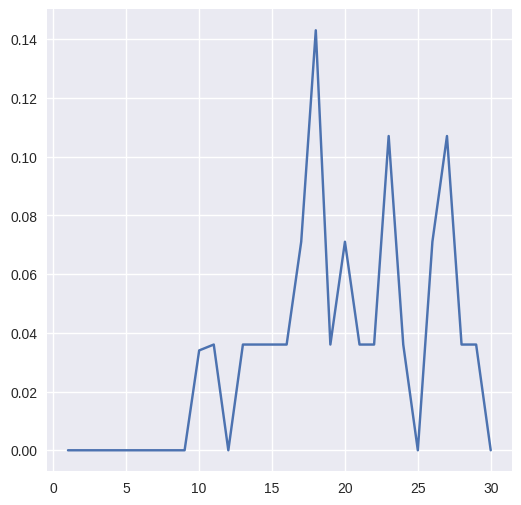

In [14]:
x, y = randomize_dist(get_bell_for_month(11, 2022)[1])

# Plotting the bell-shaped curve
plt.style.use('seaborn')
plt.figure(figsize = (6, 6))
plt.plot(x, y)
print("y: ", sum(y))

In [15]:
durations = [i+1 for i in range(8)]
duration_probs = [0.25, 0.24, 0.21, 0.09, 0.08, 0.07, 0.05, 0.01]

In [17]:
driver_year_probs = get_year_probs(1)
driver_violation_ranges = []
max_year=2022
for i in range(len(driver_violation_table)): #len(driver_violation_table)
    driver_viol = driver_violation_table[i]
    driver_id = driver_viol["driver_id"]
    total_violations = driver_viol["total_violations"]
    driver_year_prob = driver_year_probs[i]
    year_counts = get_year_by_year_counts(driver_year_prob, total_violations)
    for k, viol_count in year_counts.items():
        year = max_year - k
        month_viol_counts = get_month_counts(viol_count, peak_around_month=driver_patterns[driver_id].get('peak_in_year'))
        for month, month_viol_count in month_viol_counts.items():
            day_viol_counts = get_day_counts(month_viol_count, month, year,
                                             peak_around_day=driver_patterns[driver_id].get('peak_in_month'),
                                             peak_around_weekday=driver_patterns[driver_id].get('peak_in_week'))
            for day, day_viol_count in day_viol_counts.items():
                viol_hours =get_hour_vals(day_viol_count)
                viol_durations = np.random.choice(durations, p=duration_probs, size=(day_viol_count))
                for i in range(day_viol_count):
                    hour = viol_hours[i]
                    min = random.randint(0, 50)
                    start_time = datetime(year=year, month=month, day=day, hour=hour, minute=min)
                    duration_hours = viol_durations[i].item()
                    end_time = start_time + timedelta(hours=duration_hours)
                    start_time_str = start_time.strftime("%Y-%m-%dT%H:%M")
                    end_time_str = end_time.strftime("%Y-%m-%dT%H:%M")
                    driver_violation_ranges.append({
                        "driver_id": driver_id,
                        "start": start_time_str,
                        "end": end_time_str,
                        "duration": duration_hours
                    })

In [18]:
from datetime import datetime, timedelta

In [19]:
datetime(year=2022, month=11, day=2).weekday()

2

In [20]:
l = {1: 'a', 2: 'b'}

In [21]:
len(l)

2

In [22]:
driver_violation_ranges

[{'driver_id': 'driver_1',
  'start': '2018-08-26T00:39',
  'end': '2018-08-26T02:39',
  'duration': 2},
 {'driver_id': 'driver_1',
  'start': '2018-08-22T05:48',
  'end': '2018-08-22T08:48',
  'duration': 3},
 {'driver_id': 'driver_1',
  'start': '2018-08-22T09:49',
  'end': '2018-08-22T15:49',
  'duration': 6},
 {'driver_id': 'driver_1',
  'start': '2018-08-16T00:42',
  'end': '2018-08-16T01:42',
  'duration': 1},
 {'driver_id': 'driver_1',
  'start': '2018-08-03T01:25',
  'end': '2018-08-03T03:25',
  'duration': 2},
 {'driver_id': 'driver_1',
  'start': '2018-08-23T01:28',
  'end': '2018-08-23T03:28',
  'duration': 2},
 {'driver_id': 'driver_1',
  'start': '2018-08-10T22:04',
  'end': '2018-08-10T23:04',
  'duration': 1},
 {'driver_id': 'driver_1',
  'start': '2018-08-10T06:05',
  'end': '2018-08-10T07:05',
  'duration': 1},
 {'driver_id': 'driver_1',
  'start': '2018-08-24T18:44',
  'end': '2018-08-24T19:44',
  'duration': 1},
 {'driver_id': 'driver_1',
  'start': '2018-08-30T18:30

In [23]:
with open("./driver_violation_ranges_v1.json", "w") as outfile:
    json.dump(driver_violation_ranges, outfile)